In [1]:
import libspn as spn
import tensorflow as tf
import numpy as np

# Params

### Data

In [2]:
# Number of values of each variable
num_vals = 10 # 20  

# Number of samples in dataset
num_samples = 1000

# Batch size
batch_size = 1000

# Num epochs
num_epochs = 30

batches_per_epoch = num_samples/batch_size
print(batches_per_epoch)
if int(batches_per_epoch) != batches_per_epoch:
    raise Exception
batches_per_epoch=int(batches_per_epoch)

1.0


### Structure

In [3]:
# Type of input distributions for dense generator
input_dist = spn.DenseSPNGenerator.InputDist.MIXTURE

# Number of input mixtures for dense generator
num_input_mixtures = 10 # 10?

### Learning

In [4]:
# Additive smoothing during learning
additive_smoothing=0
min_additive_smoothing=0
smoothing_decay=0.2
initial_accum_value = 100

# Weight initialization
# weight_init_value = 1
weight_init_value = spn.ValueType.RANDOM_UNIFORM(0, 1)

# Type of inference during upward pass of learning
value_inference_type = spn.InferenceType.MARGINAL

# Add random values before max
add_random=None

use_unweighted=True

# Generate Training Set

In [5]:
components = [spn.GaussianMixtureDataset.Component(0.1, [1,1], [[1,0],[0,1]]),
              spn.GaussianMixtureDataset.Component(0.2, [1,4], [[1,0.4],[0.8,1]]),
              spn.GaussianMixtureDataset.Component(0.1, [1,8], [[1,0],[0,1]]),
              spn.GaussianMixtureDataset.Component(0.1, [3,4], [[0.5,0],[0,0.7]]),
              spn.GaussianMixtureDataset.Component(0.1, [3,8], [[1,0],[0,1]]),
              spn.GaussianMixtureDataset.Component(0.1, [5,4], [[1,0],[0,1]]),
              spn.GaussianMixtureDataset.Component(0.3, [5,1], [[1,0.5],[0.5,1]])]

train_set = spn.GaussianMixtureDataset(components=components,
                                     num_samples=num_samples,
                                     num_epochs=num_epochs,
                                     batch_size=batch_size,
                                     shuffle=True,
                                     num_threads=1,
                                     allow_smaller_final_batch=False,
                                     num_vals=num_vals)

In [6]:
train_samples, labels, true_likelihoods = train_set.get_data()

[INFO] [spn.Dataset:get_data] Building dataset operations


# Generate SPN Structure

In [7]:
ivs = spn.IVs(num_vars=2, num_vals=num_vals)
dense_gen = spn.DenseSPNGenerator(num_decomps=1, num_subsets=2, num_mixtures=1, 
                                  input_dist=input_dist, 
                                  num_input_mixtures=num_input_mixtures)
root = dense_gen.generate(ivs)
spn.generate_weights(root, init_value=weight_init_value)

# Inspect

In [8]:
print("Number of nodes: ", root.get_num_nodes())
print("\nScope of root: ", root.get_scope())
print("\nIs the graph valid?: ", root.is_valid())
print("\nTF graph size: ", root.get_tf_graph_size())

Number of nodes:  143

Scope of root:  [Scope({IVs:1, IVs:0})]

Is the graph valid?:  True

TF graph size:  319


# Visualize the SPN graph

In [9]:
spn.display_spn_graph(root)

In [10]:
spn.display_tf_graph()

# Add Learning Ops

In [11]:
ivs.attach_feed(train_samples)
additive_smoothing_var = tf.Variable(additive_smoothing, dtype=spn.conf.dtype)
learning = spn.EMLearning(root, log=True, value_inference_type = value_inference_type,
                          additive_smoothing=additive_smoothing_var, add_random=add_random,
                         initial_accum_value=initial_accum_value, use_unweighted=use_unweighted)
init_weights = spn.initialize_weights(root)
reset_accumulators = learning.reset_accumulators()
accumulate_updates = learning.accumulate_updates()
update_spn = learning.update_spn()
train_likelihood=learning.value.values[root]
avg_train_likelihood = tf.reduce_mean(train_likelihood)

In [12]:
spn.display_tf_graph()

# Add Pruning

In [13]:
pruning = spn.Pruning(root)

# Generate Test Set

In [14]:
test_set = spn.IntGridDataset(num_dims=2,
                              num_vals=num_vals,
                              num_epochs=1,
                              batch_size=1000,
                              shuffle=False,
                              num_threads=1,
                              allow_smaller_final_batch=True)

In [15]:
test_samples = test_set.get_data()

[INFO] [spn.Dataset:get_data] Building dataset operations


# Add Testing Ops

In [16]:
ivs.attach_feed(test_samples)

In [17]:
test_likelihoods = root.get_log_value(inference_type=spn.InferenceType.MARGINAL)

In [18]:
spn.display_tf_graph()

# Run

In [19]:
with spn.session() as (sess, run):
    sess.run(additive_smoothing_var.initializer)
    sess.run(init_weights)
    sess.run(reset_accumulators)
      
    # Run training
    epoch=1
    epoch_done=0
    epoch_batch=0
    try:
        while run():
            # Calculcate epoch and batch
            epoch_batch+=1
            if epoch_batch>batches_per_epoch:
                epoch_batch=1
                epoch+=1
            print("Epoch: %s Batch: %s" % (epoch, epoch_batch))
            # Every epoch, including first
            if epoch_done != epoch:
                epoch_done = epoch
                # Save SPN
                saver=spn.JSONSaver("hard_em_learning/model_%s.spn" % (epoch-1), pretty=True)
                saver.save(root)
                # Reset/init accumulators
                # sess.run(reset_accumulators)
                # Adjust additive smoothing
                ads=max(np.exp(-(epoch-1)*smoothing_decay)*additive_smoothing, min_additive_smoothing)
                sess.run(additive_smoothing_var.assign(ads))
                print("Smoothing: ", sess.run(additive_smoothing_var))
                print("Accumulators RESET!")
            # Run accumulate_updates
            train_samples_arr, labels_arr, train_likelihoods_arr, avg_train_likelihood_val, \
            true_likelihoods_arr, _, \
            root_accum_arr, root_weights = \
                sess.run([train_samples, labels, 
                          train_likelihood, avg_train_likelihood,
                          true_likelihoods,
                          accumulate_updates,
                          # Testing
                          learning.root_accum(), root.weights.node.variable
                         ])
            # Print avg likelihood of this batch data on previous batch weights
            print("Avg likelihood (this batch data on previous weights): %s" % (avg_train_likelihood_val))

            # ----------------------------
            # TEST STUFF
            # - accumulator for root
            # print("This batch data:", train_samples_arr)
            print("This batch accum:", root_accum_arr)
            print("Preious batch weights:", root_weights)
            
            # ----------------------------

            # Update weights
            sess.run(update_spn)
            
    except tf.errors.OutOfRangeError:
        # Save the lates param values from TF graph
        pruning.save_param_values()
        print("TRAINING DONE!")
    
    # Run testing
    try:
        while run():
            test_samples_arr, test_likelihoods_arr = sess.run([test_samples, test_likelihoods])
#            spn.plot_2d(test_samples_arr[:, 0], test_samples_arr[:, 1], probs=likelihoods_arr.ravel(), jitter=False)
    except tf.errors.OutOfRangeError:
        print("TESTING DONE!")


[INFO] [spn.JSONSaver:save] Saving SPN graph rooted in 'Node' to file 'hard_em_learning/model_0.spn'


Epoch: 1 Batch: 1
Smoothing:  0.0
Accumulators RESET!


[INFO] [spn.JSONSaver:save] Saving SPN graph rooted in 'Node' to file 'hard_em_learning/model_1.spn'


Avg likelihood (this batch data on previous weights): -4.68898
This batch accum: [ 100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.
  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.
  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.
  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.
  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.
  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.
  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.
  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.
  100.  100.  100.  100.]
Preious batch weights: [  3.78131913e-03   1.72150750e-02   2.17569992e-03   2.35892576e-03
   1.12417135e-02   1.76116042e-02   1.70848966e-02   4.31688532e-04
   1.26324734e-02   6.17806427e-03   5.81128523e-03   1.37745840e-02
   1.75600518e-02   1.48835322e-02   1.37220658e-02   9.90301184e-03
   8.96096

[INFO] [spn.JSONSaver:save] Saving SPN graph rooted in 'Node' to file 'hard_em_learning/model_2.spn'


Avg likelihood (this batch data on previous weights): -4.51958
This batch accum: [ 100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  136.
  157.  143.  100.  125.  158.  100.  100.  101.  100.  100.  100.  100.
  100.  100.  100.  100.  100.  100.  100.  119.  127.  125.  100.  102.
  117.  100.  100.  100.  100.  109.  115.  119.  100.  108.  123.  100.
  100.  100.  100.  100.  100.  100.  100.  100.  101.  100.  100.  100.
  100.  121.  200.  113.  100.  179.  116.  100.  100.  100.  100.  121.
  119.  130.  100.  102.  122.  100.  100.  100.  100.  115.  146.  111.
  100.  138.  112.  100.  100.  100.  100.  138.  164.  114.  100.  132.
  122.  100.  100.  100.]
Preious batch weights: [ 0.00909091  0.00909091  0.00909091  0.00909091  0.00909091  0.00909091
  0.00909091  0.00909091  0.00909091  0.00909091  0.00909091  0.01236364
  0.01427273  0.013       0.00909091  0.01136364  0.01436364  0.00909091
  0.00909091  0.00918182  0.00909091  0.00909091  0.00909091  0.009

[INFO] [spn.JSONSaver:save] Saving SPN graph rooted in 'Node' to file 'hard_em_learning/model_3.spn'


Avg likelihood (this batch data on previous weights): -4.45078
This batch accum: [ 100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  172.
  214.  186.  100.  150.  216.  100.  100.  102.  100.  100.  100.  100.
  100.  100.  100.  100.  100.  100.  100.  138.  154.  150.  100.  104.
  134.  100.  100.  100.  100.  118.  130.  138.  100.  116.  146.  100.
  100.  100.  100.  100.  100.  100.  100.  100.  102.  100.  100.  100.
  100.  142.  300.  126.  100.  258.  132.  100.  100.  100.  100.  142.
  138.  160.  100.  104.  144.  100.  100.  100.  100.  130.  192.  122.
  100.  176.  124.  100.  100.  100.  100.  176.  228.  128.  100.  164.
  144.  100.  100.  100.]
Preious batch weights: [ 0.00833333  0.00833333  0.00833333  0.00833333  0.00833333  0.00833333
  0.00833333  0.00833333  0.00833333  0.00833333  0.00833333  0.01433333
  0.01783333  0.0155      0.00833333  0.0125      0.018       0.00833333
  0.00833333  0.0085      0.00833333  0.00833333  0.00833333  0.008

[INFO] [spn.JSONSaver:save] Saving SPN graph rooted in 'Node' to file 'hard_em_learning/model_4.spn'


Avg likelihood (this batch data on previous weights): -4.39371
This batch accum: [ 100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  208.
  271.  229.  100.  175.  274.  100.  100.  103.  100.  100.  100.  100.
  100.  100.  100.  100.  100.  100.  100.  157.  181.  175.  100.  106.
  151.  100.  100.  100.  100.  127.  145.  157.  100.  124.  169.  100.
  100.  100.  100.  100.  100.  100.  100.  100.  103.  100.  100.  100.
  100.  163.  400.  139.  100.  337.  148.  100.  100.  100.  100.  163.
  157.  190.  100.  106.  166.  100.  100.  100.  100.  145.  238.  133.
  100.  214.  136.  100.  100.  100.  100.  214.  292.  142.  100.  196.
  166.  100.  100.  100.]
Preious batch weights: [ 0.00769231  0.00769231  0.00769231  0.00769231  0.00769231  0.00769231
  0.00769231  0.00769231  0.00769231  0.00769231  0.00769231  0.016
  0.02084615  0.01761539  0.00769231  0.01346154  0.02107692  0.00769231
  0.00769231  0.00792308  0.00769231  0.00769231  0.00769231  0.00769231

[INFO] [spn.JSONSaver:save] Saving SPN graph rooted in 'Node' to file 'hard_em_learning/model_5.spn'


Avg likelihood (this batch data on previous weights): -4.34574
This batch accum: [ 100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  244.
  328.  272.  100.  200.  332.  100.  100.  104.  100.  100.  100.  100.
  100.  100.  100.  100.  100.  100.  100.  176.  208.  200.  100.  108.
  168.  100.  100.  100.  100.  136.  160.  176.  100.  132.  192.  100.
  100.  100.  100.  100.  100.  100.  100.  100.  104.  100.  100.  100.
  100.  184.  500.  152.  100.  416.  164.  100.  100.  100.  100.  184.
  176.  220.  100.  108.  188.  100.  100.  100.  100.  160.  284.  144.
  100.  252.  148.  100.  100.  100.  100.  252.  356.  156.  100.  228.
  188.  100.  100.  100.]
Preious batch weights: [ 0.00714286  0.00714286  0.00714286  0.00714286  0.00714286  0.00714286
  0.00714286  0.00714286  0.00714286  0.00714286  0.00714286  0.01742857
  0.02342857  0.01942857  0.00714286  0.01428571  0.02371429  0.00714286
  0.00714286  0.00742857  0.00714286  0.00714286  0.00714286  0.007

[INFO] [spn.JSONSaver:save] Saving SPN graph rooted in 'Node' to file 'hard_em_learning/model_6.spn'


Avg likelihood (this batch data on previous weights): -4.305
This batch accum: [ 100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  280.
  385.  315.  100.  225.  390.  100.  100.  105.  100.  100.  100.  100.
  100.  100.  100.  100.  100.  100.  100.  195.  235.  225.  100.  110.
  185.  100.  100.  100.  100.  145.  175.  195.  100.  140.  215.  100.
  100.  100.  100.  100.  100.  100.  100.  100.  105.  100.  100.  100.
  100.  205.  600.  165.  100.  495.  180.  100.  100.  100.  100.  205.
  195.  250.  100.  110.  210.  100.  100.  100.  100.  175.  330.  155.
  100.  290.  160.  100.  100.  100.  100.  290.  420.  170.  100.  260.
  210.  100.  100.  100.]
Preious batch weights: [ 0.00666667  0.00666667  0.00666667  0.00666667  0.00666667  0.00666667
  0.00666667  0.00666667  0.00666667  0.00666667  0.00666667  0.01866667
  0.02566667  0.021       0.00666667  0.015       0.026       0.00666667
  0.00666667  0.007       0.00666667  0.00666667  0.00666667  0.00666

[INFO] [spn.JSONSaver:save] Saving SPN graph rooted in 'Node' to file 'hard_em_learning/model_7.spn'


Avg likelihood (this batch data on previous weights): -4.27012
This batch accum: [ 100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  316.
  442.  358.  100.  250.  448.  100.  100.  106.  100.  100.  100.  100.
  100.  100.  100.  100.  100.  100.  100.  214.  262.  250.  100.  112.
  202.  100.  100.  100.  100.  154.  190.  214.  100.  148.  238.  100.
  100.  100.  100.  100.  100.  100.  100.  100.  106.  100.  100.  100.
  100.  226.  700.  178.  100.  574.  196.  100.  100.  100.  100.  226.
  214.  280.  100.  112.  232.  100.  100.  100.  100.  190.  376.  166.
  100.  328.  172.  100.  100.  100.  100.  328.  484.  184.  100.  292.
  232.  100.  100.  100.]
Preious batch weights: [ 0.00625   0.00625   0.00625   0.00625   0.00625   0.00625   0.00625
  0.00625   0.00625   0.00625   0.00625   0.01975   0.027625  0.022375
  0.00625   0.015625  0.028     0.00625   0.00625   0.006625  0.00625
  0.00625   0.00625   0.00625   0.00625   0.00625   0.00625   0.00625
  0.0

[INFO] [spn.JSONSaver:save] Saving SPN graph rooted in 'Node' to file 'hard_em_learning/model_8.spn'


Avg likelihood (this batch data on previous weights): -4.23999
This batch accum: [ 100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  352.
  499.  401.  100.  275.  506.  100.  100.  107.  100.  100.  100.  100.
  100.  100.  100.  100.  100.  100.  100.  233.  289.  275.  100.  114.
  219.  100.  100.  100.  100.  163.  205.  233.  100.  156.  261.  100.
  100.  100.  100.  100.  100.  100.  100.  100.  107.  100.  100.  100.
  100.  247.  800.  191.  100.  653.  212.  100.  100.  100.  100.  247.
  233.  310.  100.  114.  254.  100.  100.  100.  100.  205.  422.  177.
  100.  366.  184.  100.  100.  100.  100.  366.  548.  198.  100.  324.
  254.  100.  100.  100.]
Preious batch weights: [ 0.00588235  0.00588235  0.00588235  0.00588235  0.00588235  0.00588235
  0.00588235  0.00588235  0.00588235  0.00588235  0.00588235  0.02070588
  0.02935294  0.02358823  0.00588235  0.01617647  0.02976471  0.00588235
  0.00588235  0.00629412  0.00588235  0.00588235  0.00588235  0.005

[INFO] [spn.JSONSaver:save] Saving SPN graph rooted in 'Node' to file 'hard_em_learning/model_9.spn'


Avg likelihood (this batch data on previous weights): -4.21378
This batch accum: [ 100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  388.
  556.  444.  100.  300.  564.  100.  100.  108.  100.  100.  100.  100.
  100.  100.  100.  100.  100.  100.  100.  252.  316.  300.  100.  116.
  236.  100.  100.  100.  100.  172.  220.  252.  100.  164.  284.  100.
  100.  100.  100.  100.  100.  100.  100.  100.  108.  100.  100.  100.
  100.  268.  900.  204.  100.  732.  228.  100.  100.  100.  100.  268.
  252.  340.  100.  116.  276.  100.  100.  100.  100.  220.  468.  188.
  100.  404.  196.  100.  100.  100.  100.  404.  612.  212.  100.  356.
  276.  100.  100.  100.]
Preious batch weights: [ 0.00555556  0.00555556  0.00555556  0.00555556  0.00555556  0.00555556
  0.00555556  0.00555556  0.00555556  0.00555556  0.00555556  0.02155556
  0.03088889  0.02466667  0.00555556  0.01666667  0.03133333  0.00555556
  0.00555556  0.006       0.00555556  0.00555556  0.00555556  0.005

[INFO] [spn.JSONSaver:save] Saving SPN graph rooted in 'Node' to file 'hard_em_learning/model_10.spn'


Avg likelihood (this batch data on previous weights): -4.19081
This batch accum: [  100.   100.   100.   100.   100.   100.   100.   100.   100.   100.
   100.   424.   613.   487.   100.   325.   622.   100.   100.   109.
   100.   100.   100.   100.   100.   100.   100.   100.   100.   100.
   100.   271.   343.   325.   100.   118.   253.   100.   100.   100.
   100.   181.   235.   271.   100.   172.   307.   100.   100.   100.
   100.   100.   100.   100.   100.   100.   109.   100.   100.   100.
   100.   289.  1000.   217.   100.   811.   244.   100.   100.   100.
   100.   289.   271.   370.   100.   118.   298.   100.   100.   100.
   100.   235.   514.   199.   100.   442.   208.   100.   100.   100.
   100.   442.   676.   226.   100.   388.   298.   100.   100.   100.]
Preious batch weights: [ 0.00526316  0.00526316  0.00526316  0.00526316  0.00526316  0.00526316
  0.00526316  0.00526316  0.00526316  0.00526316  0.00526316  0.02231579
  0.03226316  0.02563158  0.00526316  0

[INFO] [spn.JSONSaver:save] Saving SPN graph rooted in 'Node' to file 'hard_em_learning/model_11.spn'


Avg likelihood (this batch data on previous weights): -4.17054
This batch accum: [  100.   100.   100.   100.   100.   100.   100.   100.   100.   100.
   100.   460.   670.   530.   100.   350.   680.   100.   100.   110.
   100.   100.   100.   100.   100.   100.   100.   100.   100.   100.
   100.   290.   370.   350.   100.   120.   270.   100.   100.   100.
   100.   190.   250.   290.   100.   180.   330.   100.   100.   100.
   100.   100.   100.   100.   100.   100.   110.   100.   100.   100.
   100.   310.  1100.   230.   100.   890.   260.   100.   100.   100.
   100.   310.   290.   400.   100.   120.   320.   100.   100.   100.
   100.   250.   560.   210.   100.   480.   220.   100.   100.   100.
   100.   480.   740.   240.   100.   420.   320.   100.   100.   100.]
Preious batch weights: [ 0.005   0.005   0.005   0.005   0.005   0.005   0.005   0.005   0.005
  0.005   0.005   0.023   0.0335  0.0265  0.005   0.0175  0.034   0.005
  0.005   0.0055  0.005   0.005   0.005  

[INFO] [spn.JSONSaver:save] Saving SPN graph rooted in 'Node' to file 'hard_em_learning/model_12.spn'


Avg likelihood (this batch data on previous weights): -4.15256
This batch accum: [  100.   100.   100.   100.   100.   100.   100.   100.   100.   100.
   100.   496.   727.   573.   100.   375.   738.   100.   100.   111.
   100.   100.   100.   100.   100.   100.   100.   100.   100.   100.
   100.   309.   397.   375.   100.   122.   287.   100.   100.   100.
   100.   199.   265.   309.   100.   188.   353.   100.   100.   100.
   100.   100.   100.   100.   100.   100.   111.   100.   100.   100.
   100.   331.  1200.   243.   100.   969.   276.   100.   100.   100.
   100.   331.   309.   430.   100.   122.   342.   100.   100.   100.
   100.   265.   606.   221.   100.   518.   232.   100.   100.   100.
   100.   518.   804.   254.   100.   452.   342.   100.   100.   100.]
Preious batch weights: [ 0.0047619   0.0047619   0.0047619   0.0047619   0.0047619   0.0047619
  0.0047619   0.0047619   0.0047619   0.0047619   0.0047619   0.02361905
  0.03461905  0.02728571  0.0047619   0.

[INFO] [spn.JSONSaver:save] Saving SPN graph rooted in 'Node' to file 'hard_em_learning/model_13.spn'


Avg likelihood (this batch data on previous weights): -4.1365
This batch accum: [  100.   100.   100.   100.   100.   100.   100.   100.   100.   100.
   100.   532.   784.   616.   100.   400.   796.   100.   100.   112.
   100.   100.   100.   100.   100.   100.   100.   100.   100.   100.
   100.   328.   424.   400.   100.   124.   304.   100.   100.   100.
   100.   208.   280.   328.   100.   196.   376.   100.   100.   100.
   100.   100.   100.   100.   100.   100.   112.   100.   100.   100.
   100.   352.  1300.   256.   100.  1048.   292.   100.   100.   100.
   100.   352.   328.   460.   100.   124.   364.   100.   100.   100.
   100.   280.   652.   232.   100.   556.   244.   100.   100.   100.
   100.   556.   868.   268.   100.   484.   364.   100.   100.   100.]
Preious batch weights: [ 0.00454545  0.00454545  0.00454545  0.00454545  0.00454545  0.00454545
  0.00454545  0.00454545  0.00454545  0.00454545  0.00454545  0.02418182
  0.03563637  0.028       0.00454545  0.

[INFO] [spn.JSONSaver:save] Saving SPN graph rooted in 'Node' to file 'hard_em_learning/model_14.spn'


Avg likelihood (this batch data on previous weights): -4.1221
This batch accum: [  100.   100.   100.   100.   100.   100.   100.   100.   100.   100.
   100.   568.   841.   659.   100.   425.   854.   100.   100.   113.
   100.   100.   100.   100.   100.   100.   100.   100.   100.   100.
   100.   347.   451.   425.   100.   126.   321.   100.   100.   100.
   100.   217.   295.   347.   100.   204.   399.   100.   100.   100.
   100.   100.   100.   100.   100.   100.   113.   100.   100.   100.
   100.   373.  1400.   269.   100.  1127.   308.   100.   100.   100.
   100.   373.   347.   490.   100.   126.   386.   100.   100.   100.
   100.   295.   698.   243.   100.   594.   256.   100.   100.   100.
   100.   594.   932.   282.   100.   516.   386.   100.   100.   100.]
Preious batch weights: [ 0.00434783  0.00434783  0.00434783  0.00434783  0.00434783  0.00434783
  0.00434783  0.00434783  0.00434783  0.00434783  0.00434783  0.02469565
  0.03656522  0.02865217  0.00434783  0.

[INFO] [spn.JSONSaver:save] Saving SPN graph rooted in 'Node' to file 'hard_em_learning/model_15.spn'


Avg likelihood (this batch data on previous weights): -4.10912
This batch accum: [  100.   100.   100.   100.   100.   100.   100.   100.   100.   100.
   100.   604.   898.   702.   100.   450.   912.   100.   100.   114.
   100.   100.   100.   100.   100.   100.   100.   100.   100.   100.
   100.   366.   478.   450.   100.   128.   338.   100.   100.   100.
   100.   226.   310.   366.   100.   212.   422.   100.   100.   100.
   100.   100.   100.   100.   100.   100.   114.   100.   100.   100.
   100.   394.  1500.   282.   100.  1206.   324.   100.   100.   100.
   100.   394.   366.   520.   100.   128.   408.   100.   100.   100.
   100.   310.   744.   254.   100.   632.   268.   100.   100.   100.
   100.   632.   996.   296.   100.   548.   408.   100.   100.   100.]
Preious batch weights: [ 0.00416667  0.00416667  0.00416667  0.00416667  0.00416667  0.00416667
  0.00416667  0.00416667  0.00416667  0.00416667  0.00416667  0.02516667
  0.03741667  0.02925     0.00416667  0

[INFO] [spn.JSONSaver:save] Saving SPN graph rooted in 'Node' to file 'hard_em_learning/model_16.spn'


Avg likelihood (this batch data on previous weights): -4.09737
This batch accum: [  100.   100.   100.   100.   100.   100.   100.   100.   100.   100.
   100.   640.   955.   745.   100.   475.   970.   100.   100.   115.
   100.   100.   100.   100.   100.   100.   100.   100.   100.   100.
   100.   385.   505.   475.   100.   130.   355.   100.   100.   100.
   100.   235.   325.   385.   100.   220.   445.   100.   100.   100.
   100.   100.   100.   100.   100.   100.   115.   100.   100.   100.
   100.   415.  1600.   295.   100.  1285.   340.   100.   100.   100.
   100.   415.   385.   550.   100.   130.   430.   100.   100.   100.
   100.   325.   790.   265.   100.   670.   280.   100.   100.   100.
   100.   670.  1060.   310.   100.   580.   430.   100.   100.   100.]
Preious batch weights: [ 0.004   0.004   0.004   0.004   0.004   0.004   0.004   0.004   0.004
  0.004   0.004   0.0256  0.0382  0.0298  0.004   0.019   0.0388  0.004
  0.004   0.0046  0.004   0.004   0.004  

[INFO] [spn.JSONSaver:save] Saving SPN graph rooted in 'Node' to file 'hard_em_learning/model_17.spn'


Avg likelihood (this batch data on previous weights): -4.08669
This batch accum: [  100.   100.   100.   100.   100.   100.   100.   100.   100.   100.
   100.   676.  1012.   788.   100.   500.  1028.   100.   100.   116.
   100.   100.   100.   100.   100.   100.   100.   100.   100.   100.
   100.   404.   532.   500.   100.   132.   372.   100.   100.   100.
   100.   244.   340.   404.   100.   228.   468.   100.   100.   100.
   100.   100.   100.   100.   100.   100.   116.   100.   100.   100.
   100.   436.  1700.   308.   100.  1364.   356.   100.   100.   100.
   100.   436.   404.   580.   100.   132.   452.   100.   100.   100.
   100.   340.   836.   276.   100.   708.   292.   100.   100.   100.
   100.   708.  1124.   324.   100.   612.   452.   100.   100.   100.]
Preious batch weights: [ 0.00384615  0.00384615  0.00384615  0.00384615  0.00384615  0.00384615
  0.00384615  0.00384615  0.00384615  0.00384615  0.00384615  0.026
  0.03892308  0.03030769  0.00384615  0.0192

[INFO] [spn.JSONSaver:save] Saving SPN graph rooted in 'Node' to file 'hard_em_learning/model_18.spn'


Avg likelihood (this batch data on previous weights): -4.07695
This batch accum: [  100.   100.   100.   100.   100.   100.   100.   100.   100.   100.
   100.   712.  1069.   831.   100.   525.  1086.   100.   100.   117.
   100.   100.   100.   100.   100.   100.   100.   100.   100.   100.
   100.   423.   559.   525.   100.   134.   389.   100.   100.   100.
   100.   253.   355.   423.   100.   236.   491.   100.   100.   100.
   100.   100.   100.   100.   100.   100.   117.   100.   100.   100.
   100.   457.  1800.   321.   100.  1443.   372.   100.   100.   100.
   100.   457.   423.   610.   100.   134.   474.   100.   100.   100.
   100.   355.   882.   287.   100.   746.   304.   100.   100.   100.
   100.   746.  1188.   338.   100.   644.   474.   100.   100.   100.]
Preious batch weights: [ 0.0037037   0.0037037   0.0037037   0.0037037   0.0037037   0.0037037
  0.0037037   0.0037037   0.0037037   0.0037037   0.0037037   0.02637037
  0.03959259  0.03077778  0.0037037   0.

[INFO] [spn.JSONSaver:save] Saving SPN graph rooted in 'Node' to file 'hard_em_learning/model_19.spn'


Avg likelihood (this batch data on previous weights): -4.06804
This batch accum: [  100.   100.   100.   100.   100.   100.   100.   100.   100.   100.
   100.   748.  1126.   874.   100.   550.  1144.   100.   100.   118.
   100.   100.   100.   100.   100.   100.   100.   100.   100.   100.
   100.   442.   586.   550.   100.   136.   406.   100.   100.   100.
   100.   262.   370.   442.   100.   244.   514.   100.   100.   100.
   100.   100.   100.   100.   100.   100.   118.   100.   100.   100.
   100.   478.  1900.   334.   100.  1522.   388.   100.   100.   100.
   100.   478.   442.   640.   100.   136.   496.   100.   100.   100.
   100.   370.   928.   298.   100.   784.   316.   100.   100.   100.
   100.   784.  1252.   352.   100.   676.   496.   100.   100.   100.]
Preious batch weights: [ 0.00357143  0.00357143  0.00357143  0.00357143  0.00357143  0.00357143
  0.00357143  0.00357143  0.00357143  0.00357143  0.00357143  0.02671429
  0.04021429  0.03121429  0.00357143  0

[INFO] [spn.JSONSaver:save] Saving SPN graph rooted in 'Node' to file 'hard_em_learning/model_20.spn'


Avg likelihood (this batch data on previous weights): -4.05985
This batch accum: [  100.   100.   100.   100.   100.   100.   100.   100.   100.   100.
   100.   784.  1183.   917.   100.   575.  1202.   100.   100.   119.
   100.   100.   100.   100.   100.   100.   100.   100.   100.   100.
   100.   461.   613.   575.   100.   138.   423.   100.   100.   100.
   100.   271.   385.   461.   100.   252.   537.   100.   100.   100.
   100.   100.   100.   100.   100.   100.   119.   100.   100.   100.
   100.   499.  2000.   347.   100.  1601.   404.   100.   100.   100.
   100.   499.   461.   670.   100.   138.   518.   100.   100.   100.
   100.   385.   974.   309.   100.   822.   328.   100.   100.   100.
   100.   822.  1316.   366.   100.   708.   518.   100.   100.   100.]
Preious batch weights: [ 0.00344828  0.00344828  0.00344828  0.00344828  0.00344828  0.00344828
  0.00344828  0.00344828  0.00344828  0.00344828  0.00344828  0.02703448
  0.0407931   0.03162069  0.00344828  0

[INFO] [spn.JSONSaver:save] Saving SPN graph rooted in 'Node' to file 'hard_em_learning/model_21.spn'


Avg likelihood (this batch data on previous weights): -4.05231
This batch accum: [  100.   100.   100.   100.   100.   100.   100.   100.   100.   100.
   100.   820.  1240.   960.   100.   600.  1260.   100.   100.   120.
   100.   100.   100.   100.   100.   100.   100.   100.   100.   100.
   100.   480.   640.   600.   100.   140.   440.   100.   100.   100.
   100.   280.   400.   480.   100.   260.   560.   100.   100.   100.
   100.   100.   100.   100.   100.   100.   120.   100.   100.   100.
   100.   520.  2100.   360.   100.  1680.   420.   100.   100.   100.
   100.   520.   480.   700.   100.   140.   540.   100.   100.   100.
   100.   400.  1020.   320.   100.   860.   340.   100.   100.   100.
   100.   860.  1380.   380.   100.   740.   540.   100.   100.   100.]
Preious batch weights: [ 0.00333333  0.00333333  0.00333333  0.00333333  0.00333333  0.00333333
  0.00333333  0.00333333  0.00333333  0.00333333  0.00333333  0.02733333
  0.04133333  0.032       0.00333333  0

[INFO] [spn.JSONSaver:save] Saving SPN graph rooted in 'Node' to file 'hard_em_learning/model_22.spn'


Avg likelihood (this batch data on previous weights): -4.04534
This batch accum: [  100.   100.   100.   100.   100.   100.   100.   100.   100.   100.
   100.   856.  1297.  1003.   100.   625.  1318.   100.   100.   121.
   100.   100.   100.   100.   100.   100.   100.   100.   100.   100.
   100.   499.   667.   625.   100.   142.   457.   100.   100.   100.
   100.   289.   415.   499.   100.   268.   583.   100.   100.   100.
   100.   100.   100.   100.   100.   100.   121.   100.   100.   100.
   100.   541.  2200.   373.   100.  1759.   436.   100.   100.   100.
   100.   541.   499.   730.   100.   142.   562.   100.   100.   100.
   100.   415.  1066.   331.   100.   898.   352.   100.   100.   100.
   100.   898.  1444.   394.   100.   772.   562.   100.   100.   100.]
Preious batch weights: [ 0.00322581  0.00322581  0.00322581  0.00322581  0.00322581  0.00322581
  0.00322581  0.00322581  0.00322581  0.00322581  0.00322581  0.0276129
  0.04183871  0.03235484  0.00322581  0.

[INFO] [spn.JSONSaver:save] Saving SPN graph rooted in 'Node' to file 'hard_em_learning/model_23.spn'


Avg likelihood (this batch data on previous weights): -4.0389
This batch accum: [  100.   100.   100.   100.   100.   100.   100.   100.   100.   100.
   100.   892.  1354.  1046.   100.   650.  1376.   100.   100.   122.
   100.   100.   100.   100.   100.   100.   100.   100.   100.   100.
   100.   518.   694.   650.   100.   144.   474.   100.   100.   100.
   100.   298.   430.   518.   100.   276.   606.   100.   100.   100.
   100.   100.   100.   100.   100.   100.   122.   100.   100.   100.
   100.   562.  2300.   386.   100.  1838.   452.   100.   100.   100.
   100.   562.   518.   760.   100.   144.   584.   100.   100.   100.
   100.   430.  1112.   342.   100.   936.   364.   100.   100.   100.
   100.   936.  1508.   408.   100.   804.   584.   100.   100.   100.]
Preious batch weights: [ 0.003125   0.003125   0.003125   0.003125   0.003125   0.003125   0.003125
  0.003125   0.003125   0.003125   0.003125   0.027875   0.0423125
  0.0326875  0.003125   0.0203125  0.043  

[INFO] [spn.JSONSaver:save] Saving SPN graph rooted in 'Node' to file 'hard_em_learning/model_24.spn'


Avg likelihood (this batch data on previous weights): -4.03291
This batch accum: [  100.   100.   100.   100.   100.   100.   100.   100.   100.   100.
   100.   928.  1411.  1089.   100.   675.  1434.   100.   100.   123.
   100.   100.   100.   100.   100.   100.   100.   100.   100.   100.
   100.   537.   721.   675.   100.   146.   491.   100.   100.   100.
   100.   307.   445.   537.   100.   284.   629.   100.   100.   100.
   100.   100.   100.   100.   100.   100.   123.   100.   100.   100.
   100.   583.  2400.   399.   100.  1917.   468.   100.   100.   100.
   100.   583.   537.   790.   100.   146.   606.   100.   100.   100.
   100.   445.  1158.   353.   100.   974.   376.   100.   100.   100.
   100.   974.  1572.   422.   100.   836.   606.   100.   100.   100.]
Preious batch weights: [ 0.0030303   0.0030303   0.0030303   0.0030303   0.0030303   0.0030303
  0.0030303   0.0030303   0.0030303   0.0030303   0.0030303   0.02812121
  0.04275757  0.033       0.0030303   0.

[INFO] [spn.JSONSaver:save] Saving SPN graph rooted in 'Node' to file 'hard_em_learning/model_25.spn'


Avg likelihood (this batch data on previous weights): -4.02734
This batch accum: [  100.   100.   100.   100.   100.   100.   100.   100.   100.   100.
   100.   964.  1468.  1132.   100.   700.  1492.   100.   100.   124.
   100.   100.   100.   100.   100.   100.   100.   100.   100.   100.
   100.   556.   748.   700.   100.   148.   508.   100.   100.   100.
   100.   316.   460.   556.   100.   292.   652.   100.   100.   100.
   100.   100.   100.   100.   100.   100.   124.   100.   100.   100.
   100.   604.  2500.   412.   100.  1996.   484.   100.   100.   100.
   100.   604.   556.   820.   100.   148.   628.   100.   100.   100.
   100.   460.  1204.   364.   100.  1012.   388.   100.   100.   100.
   100.  1012.  1636.   436.   100.   868.   628.   100.   100.   100.]
Preious batch weights: [ 0.00294118  0.00294118  0.00294118  0.00294118  0.00294118  0.00294118
  0.00294118  0.00294118  0.00294118  0.00294118  0.00294118  0.02835294
  0.04317647  0.03329412  0.00294118  0

[INFO] [spn.JSONSaver:save] Saving SPN graph rooted in 'Node' to file 'hard_em_learning/model_26.spn'


Avg likelihood (this batch data on previous weights): -4.02215
This batch accum: [  100.   100.   100.   100.   100.   100.   100.   100.   100.   100.
   100.  1000.  1525.  1175.   100.   725.  1550.   100.   100.   125.
   100.   100.   100.   100.   100.   100.   100.   100.   100.   100.
   100.   575.   775.   725.   100.   150.   525.   100.   100.   100.
   100.   325.   475.   575.   100.   300.   675.   100.   100.   100.
   100.   100.   100.   100.   100.   100.   125.   100.   100.   100.
   100.   625.  2600.   425.   100.  2075.   500.   100.   100.   100.
   100.   625.   575.   850.   100.   150.   650.   100.   100.   100.
   100.   475.  1250.   375.   100.  1050.   400.   100.   100.   100.
   100.  1050.  1700.   450.   100.   900.   650.   100.   100.   100.]
Preious batch weights: [ 0.00285714  0.00285714  0.00285714  0.00285714  0.00285714  0.00285714
  0.00285714  0.00285714  0.00285714  0.00285714  0.00285714  0.02857143
  0.04357143  0.03357143  0.00285714  0

[INFO] [spn.JSONSaver:save] Saving SPN graph rooted in 'Node' to file 'hard_em_learning/model_27.spn'


Avg likelihood (this batch data on previous weights): -4.0173
This batch accum: [  100.   100.   100.   100.   100.   100.   100.   100.   100.   100.
   100.  1036.  1582.  1218.   100.   750.  1608.   100.   100.   126.
   100.   100.   100.   100.   100.   100.   100.   100.   100.   100.
   100.   594.   802.   750.   100.   152.   542.   100.   100.   100.
   100.   334.   490.   594.   100.   308.   698.   100.   100.   100.
   100.   100.   100.   100.   100.   100.   126.   100.   100.   100.
   100.   646.  2700.   438.   100.  2154.   516.   100.   100.   100.
   100.   646.   594.   880.   100.   152.   672.   100.   100.   100.
   100.   490.  1296.   386.   100.  1088.   412.   100.   100.   100.
   100.  1088.  1764.   464.   100.   932.   672.   100.   100.   100.]
Preious batch weights: [ 0.00277778  0.00277778  0.00277778  0.00277778  0.00277778  0.00277778
  0.00277778  0.00277778  0.00277778  0.00277778  0.00277778  0.02877778
  0.04394444  0.03383333  0.00277778  0.

[INFO] [spn.JSONSaver:save] Saving SPN graph rooted in 'Node' to file 'hard_em_learning/model_28.spn'


Avg likelihood (this batch data on previous weights): -4.01276
This batch accum: [  100.   100.   100.   100.   100.   100.   100.   100.   100.   100.
   100.  1072.  1639.  1261.   100.   775.  1666.   100.   100.   127.
   100.   100.   100.   100.   100.   100.   100.   100.   100.   100.
   100.   613.   829.   775.   100.   154.   559.   100.   100.   100.
   100.   343.   505.   613.   100.   316.   721.   100.   100.   100.
   100.   100.   100.   100.   100.   100.   127.   100.   100.   100.
   100.   667.  2800.   451.   100.  2233.   532.   100.   100.   100.
   100.   667.   613.   910.   100.   154.   694.   100.   100.   100.
   100.   505.  1342.   397.   100.  1126.   424.   100.   100.   100.
   100.  1126.  1828.   478.   100.   964.   694.   100.   100.   100.]
Preious batch weights: [ 0.0027027   0.0027027   0.0027027   0.0027027   0.0027027   0.0027027
  0.0027027   0.0027027   0.0027027   0.0027027   0.0027027   0.02897297
  0.0442973   0.03408108  0.0027027   0.

[INFO] [spn.JSONSaver:save] Saving SPN graph rooted in 'Node' to file 'hard_em_learning/model_29.spn'


Avg likelihood (this batch data on previous weights): -4.0085
This batch accum: [  100.   100.   100.   100.   100.   100.   100.   100.   100.   100.
   100.  1108.  1696.  1304.   100.   800.  1724.   100.   100.   128.
   100.   100.   100.   100.   100.   100.   100.   100.   100.   100.
   100.   632.   856.   800.   100.   156.   576.   100.   100.   100.
   100.   352.   520.   632.   100.   324.   744.   100.   100.   100.
   100.   100.   100.   100.   100.   100.   128.   100.   100.   100.
   100.   688.  2900.   464.   100.  2312.   548.   100.   100.   100.
   100.   688.   632.   940.   100.   156.   716.   100.   100.   100.
   100.   520.  1388.   408.   100.  1164.   436.   100.   100.   100.
   100.  1164.  1892.   492.   100.   996.   716.   100.   100.   100.]
Preious batch weights: [ 0.00263158  0.00263158  0.00263158  0.00263158  0.00263158  0.00263158
  0.00263158  0.00263158  0.00263158  0.00263158  0.00263158  0.0291579
  0.04463158  0.03431579  0.00263158  0.0

[INFO] [spn.JSONSaver:save] Saving SPN graph rooted in 'Node' to file 'hard_em_learning/model_30.spn'


Avg likelihood (this batch data on previous weights): -4.00451
This batch accum: [  100.   100.   100.   100.   100.   100.   100.   100.   100.   100.
   100.  1144.  1753.  1347.   100.   825.  1782.   100.   100.   129.
   100.   100.   100.   100.   100.   100.   100.   100.   100.   100.
   100.   651.   883.   825.   100.   158.   593.   100.   100.   100.
   100.   361.   535.   651.   100.   332.   767.   100.   100.   100.
   100.   100.   100.   100.   100.   100.   129.   100.   100.   100.
   100.   709.  3000.   477.   100.  2391.   564.   100.   100.   100.
   100.   709.   651.   970.   100.   158.   738.   100.   100.   100.
   100.   535.  1434.   419.   100.  1202.   448.   100.   100.   100.
   100.  1202.  1956.   506.   100.  1028.   738.   100.   100.   100.]
Preious batch weights: [ 0.0025641   0.0025641   0.0025641   0.0025641   0.0025641   0.0025641
  0.0025641   0.0025641   0.0025641   0.0025641   0.0025641   0.02933333
  0.04494872  0.03453846  0.0025641   0.

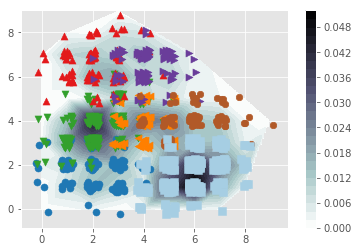

In [20]:
spn.plot_2d(train_samples_arr[:, 0], train_samples_arr[:, 1], labels=labels_arr[:, 0], probs=true_likelihoods_arr)

In [21]:
# spn.plot_2d(train_samples_arr[:, 0], train_samples_arr[:, 1], labels=labels_arr[:, 0],
#             probs=(np.exp(train_likelihoods_arr.ravel())), jitter=True)

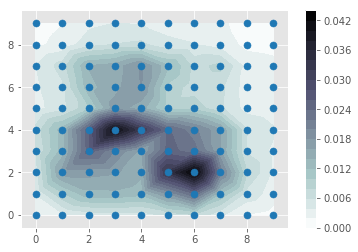

In [22]:
spn.plot_2d(test_samples_arr[:, 0], test_samples_arr[:, 1], 
            probs=(np.exp(test_likelihoods_arr.ravel())), jitter=False)

In [23]:
# for s, l in zip(test_samples_arr, likelihoods_arr):
#    print(s.tolist(), l.tolist())

# Pruning

### Perform pruning

In [24]:
pruning.prune(threshold=0.005)

### Add Testing Ops Post-Pruning

In [25]:
ivs.attach_feed(test_samples)

In [26]:
reinit_weights = spn.initialize_weights(root)
pruned_test_likelihoods = root.get_log_value(inference_type=spn.InferenceType.MARGINAL)

### Inspect Pruned Network

In [27]:
print("Number of nodes: ", root.get_num_nodes())
print("\nScope of root: ", root.get_scope())
print("\nIs the graph valid?: ", root.is_valid())
print("\nTF graph size: ", root.get_tf_graph_size())

Number of nodes:  60

Scope of root:  [Scope({IVs:1, IVs:0})]

Is the graph valid?:  True

TF graph size:  4959


### Visualize Pruned SPN graph

In [28]:
spn.display_spn_graph(root)

In [29]:
spn.display_tf_graph()

# Add Learning Ops

In [30]:
spn.display_tf_graph()

# Retest with Pruned Network

In [31]:
with spn.session() as (sess, run):
    sess.run(reinit_weights)
    
    # Run testing
    try:
        while run():
            test_samples_arr, pruned_test_likelihoods_arr = sess.run([test_samples, pruned_test_likelihoods])
    except tf.errors.OutOfRangeError:
        print("RETESTING DONE!")

RETESTING DONE!


# Plot Pruned Test Likelihood

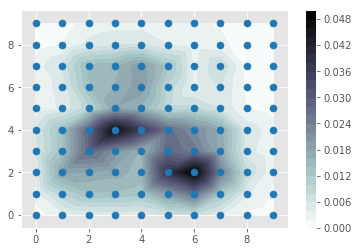

In [32]:
spn.plot_2d(test_samples_arr[:, 0], test_samples_arr[:, 1], 
            probs=(np.exp(pruned_test_likelihoods_arr.ravel())), jitter=False)

# Scratch

In [33]:
local_vars=tf.local_variables()

In [34]:
local_vars[0].name

'Dataset/input_producer/input_producer/limit_epochs/epochs:0'

In [35]:
local_vars[1].name

'Dataset_1/input_producer/input_producer/limit_epochs/epochs:0'